#                       Travail personel phys-f-303: Monte Carlo

Tarfi Otman

Nous verrons à travers ce mooc comment simplifier des problèmes dont il y a un grand nombre de degré de liberté

Les réponses aux questions et aux challenges sont écrit en vert sur fond noir et en français. 

## Random walk

In module 4 of the open course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about) you learned how to simulate numerically diffusion problems through their partial differential equations. Here we look again at diffusion but address it using a completely different method.

Consider once more the spreading out of a drop of food dye in a cup of water.

In [579]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/f/f9/Blausen_0315_Diffusion.png')

If you zoom in on a molecule of dye, you will observe that it follows an erratic trajectory as it constantly collides with the surronding molecules of water.

In [580]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/c/c2/Brownian_motion_large.gif')

This phenomenon, known as Brownian motion, can be observed when looking at dilitued pollen through a microscope (as the botanist Robert Brown did in 1827) and was attributed to the collision with water molecules by Albert Einstein in a 1905 article. 

One way to simulate the dispersion of the dye within the fluid is to model its dispersion using the diffusion equation we studied in module 4:


$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}.
$$

Here the quantity we are interested in is the density $\rho$ of the molecules of dye. More precisely, for any small volume $dV$ of fluid centered around $x$, $\rho(x) dV$ represents the number of molecules of dye contained within this volume, divided by their total number. This method has the advantage of being rather lightweight from the numerical point of view; however it does not provide any detail about the trajectories of particles as only their average positions is available through $\rho$.

Another way to compute the spreading of the dye is to track the motion of the individual molecules using Newton's laws of motion:

$$
v = \frac{dx}{dt}\\
\frac{dv}{dt}=\frac{F}{m}
$$

In the above equations, $x$, $v$, $m$ and $F$ are respectively the position, the velocity, the mass and the force acting on any given molecule. This method is simple conceptually and generates an immense quantity of information as the trajectory of every single molecule is computed. However, the problem with this approach is that a glass of water typically contains of the order of $10^{23}$ molecules. We therefore would need to solve a huge coupled system of equations which is beyond the reach of even big computers.

We can however find a 'middle ground' between modelling the process with the diffusion equation and explicitely solving the equation of motion for all the molecules.

In it's simplest version, our model for Brownian motion is obtained by rewriting the evolution of the position a molecule of dye as:

$$
dx = x(t+dt) - x(t) = ds
$$

If you look again at the animation of Brownian motion shown above, you should notice that the trajectory of a molecule of dye *looks* erratic. It seems that the molecule, as it is constantly being hit by the molecules of water, jumps randomly from one location to another nearby location. We therefore speak of a *random walk*. The whole idea is therefore to model $ds$ as a random displacement with the correct statistical properties so that on average, the simulated trajectories mimic a diffusion process.

In order to construct an algorithm in which $ds$ is evaluated using random numbers, we will first look into how our computer draws these numbers and how to make sure they have the right statistics to describe Brownian motion. This topic is addressed in the second notebook of this module. We will return to our random walk just after that...

# Random numbers

Monte Carlo methods heavily rely on random numbers. Classical computers can only execute deterministic operations. In particular they cannot be used to generate stochastic quantities like random variables. However it is possible to design deterministic algorithms capable to generate series of number that, to some extent, resemble random numbers. In practical applications a large number of random numbers is required. It is therefore essential of being able to generate good quality random numbers efficiently. This is not such an easy task!

Discussing all the practical and theoretical issues involved is beyond the scope of this introduction and we will rely on NumPy's built-in functions.

To avoid confusion, let's recall a couple of definitions:

- The **cumulative distribution function** $F(x)$ of a random process measures the probability for the outcome of an event to have a value less than or equal to $x$. Obviously we should have $F(x\rightarrow -\infty)=0$ and $F(x\rightarrow \infty)=1$.

- The **probability distribution function** measures how likely the outcome of an event "will be close" to $x$. More precisely, it is defined as the derivative of the cumulative distribution,
$$
p(x)=\frac{dF}{dx}(x)\Leftrightarrow F(x)=\int_{-\infty}^x p(y)dy.
$$
In other words, for small $\Delta x$, $p(x)\Delta x$ represents the probability for the event to have a value lying between $x$ and $x+\Delta x$.

## Uniform random distribution

The most basic distribution function is the uniform distribution. It describes a sequence of random numbers that are distributed in a given interval $[a,b]$ with equal probability. As $p(x)$ is a constant in the interval $[a,b]$ and $\int_{-\infty}^{\infty} p(x)dx = 1$, one has,
$$
p(x) = 
\begin{cases} \frac{1}{b-a} &\mbox{if } x\in [a,b] \\ 
0 & \mbox{otherwise } 
\end{cases} 
$$

Let us see how to produce such a distribution using Python. As usual, we first import a few libraries.

In [581]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [582]:
# Let's draw one random number
x = numpy.random.random_sample()
print(x)

0.36918169718110505


If you execute the above piece of code several times, you will notice that each time you will get a different number from 0 to 1. As the function `numpy.random.random_sample()` samples uniformly between 0 and 1, all the numbers in this interval have equal probabilities of being chosen (note that 0 is a possible output while 1 is excluded; one says that the numbers are drawn in the interval [0,1) instead of [0 1]). 

If you know in advance how many random numbers you would like to draw, you may also specify this as an option and `numpy.random.random_sample()` will return an appropriately sized array:

In [583]:
# We draw ten random numbers
x = numpy.random.random_sample(10)
print(x)

[ 0.46830158  0.81072319  0.67329375  0.60757332  0.58739595  0.30702755
  0.40596856  0.46175914  0.3606044   0.72629186]


### Are the numbers really random?

You may wonder how your computer is able to draw these random numbers and if they are really random. In fact, they are not. As we anticipated above, the internal algorithm produces a perfectly repeatable sequence of numbers that only look like random. In particular, after a (very) large number of draws, the sequence will repeat itself.

When you start Python (through the notebook for example), the system picks a starting place in the sequence and then produces all the following numbers in the sequence at each call of the `numpy.random.random_sample()` function. You may however pick the starting place in the sequence yourself and therefore draw a perfectly reproducible set of numbers. This is done by specifying the so-called 'seed' of the generator like this:

In [584]:
numpy.random.seed(0)
x = numpy.random.random_sample(10)
print(x)

[ 0.5488135   0.71518937  0.60276338  0.54488318  0.4236548   0.64589411
  0.43758721  0.891773    0.96366276  0.38344152]


If you repeat the above piece of code several times, you will observe that the floats returned are always identical! The seed, 0 in this case, is an integer that fixes a starting place in the sequence of "pseudo-random" numbers. Choose a different value for the seed and see what happens.

Now try the following code:

In [585]:
numpy.random.seed(0)
x = numpy.random.random_sample(5)
print(x)
x = numpy.random.random_sample(5)
print(x)


[ 0.5488135   0.71518937  0.60276338  0.54488318  0.4236548 ]
[ 0.64589411  0.43758721  0.891773    0.96366276  0.38344152]


Compare this to the previous 10 numbers generated (with seed=0). Do you see what is happening?

<p style='color:green; background-color:black; text-align:center'>
Dans la grande liste pré-défini des nombres aléatoires de Python,nous avons reset l'emplacement où on était sur cette longue liste à l'aide de la fonction numpy.random.seed() et commençons du début; on affiche les 5 chiffres suivants; De nouveau à l'aide de la fonction numpy.random.seed() en précisant l'emplacement 5, on reprend les 5 chiffres suivants à partir de la 5ème place <br>
Cela revient donc d'aficher les 10 nombres de la liste à partir de l'emplacement 0 (début de la liste)
</p>

Setting the seed of the random number generator can be very useful if you want to debug a code and have a repeatable output. However, when you perform a real computation, you should let the system pick a seed at random based on the date and time for example. This is done each time python starts but you may also do it yourself by calling `numpy.random.seed()` without any argument.

### Uniform distribution in the interval [a,b)

Producing a sample of random numbers in the interval [a,b) instead of just [0,1) is easy. It is achieved by first drawing the numbers between 0 and 1 and then 'rescaling' the output:

In [586]:
a=5
b=20
x = numpy.random.random_sample(10)
y = (b-a)*x+a
print(y)

[ 16.87587557  12.9334238   13.52066842  18.88394957   6.06554087
   6.3069395    5.30327596  17.48929768  16.67235126  18.05018222]


## Visualising the histogram of the random sample

Our little code above is designed to return a sample of numbers between 5 and 20 with equal probability and one therefore speaks of a uniform random distribution. A nice way of checking this consists in plotting the histogram of the random numbers generated. In a histogram, the interval of interest is first divided into smaller intervals called bins. For each bin, the histogram displays the number of occurances of the random sequence that have a value within the bin. Let's try it:

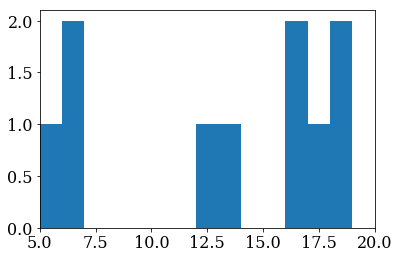

In [587]:
binwidth=1
pyplot.xlim(5,20)
pyplot.hist(y,bins=numpy.arange(5.,21., binwidth),normed=False);

By examining the histogram you should be able to confirm how many random numbers drawn above fall in each bin (in this case we have created bins that span the intervals [i,i+1) where i are the integers between 5 and 19).

Of course, the above histogram is far from uniform; we only drew 10 random numbers so there was no chance of having the same number of occurances in each bin (we have 15 of them!). The distribution will only appear uniform if we draw a large amount of random numbers and the fluctuations in the histogram are smoothed out. Try it, redraw the histogram for 10000, or even 1000000 random numbers. 

Finally, you should draw the histogram with the option 'normed=True'. That way, all the values computed will be divided by the total number of random numbers drawn and provide the frequency of obtaining a random number in any given bin. As you increase the size of your random numbers sample and decrease the size of the bins, this frequency converges to the probability distribution function of the random numbers. Does it work?

<p style='color:green; background-color:black; text-align:center'>
Augmentons le nombre de processus aléatoires et diminuons la taille des boîtes:
</p>

<p style='background-color:green'>
<br>
<br>
<br>
<br>
<br>
</p>

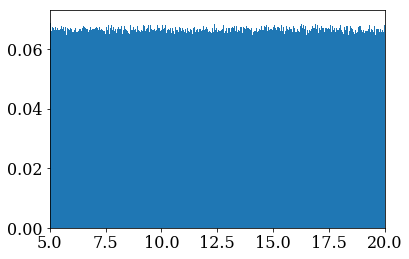

In [588]:
x = numpy.random.random_sample(10000000)
y = (b-a)*x+a
binwidth=10**(-2)
pyplot.xlim(5,20)
pyplot.hist(y,bins=numpy.arange(5.,21., binwidth),normed=True);

<p style='background-color:green'>
<br>
<br>
<br>
<br>
<br>
</p>

<p style='color:green; background-color:black; text-align:center'>
Comme nous nous attendons, on converge bien vers la fonction de distribution de probabilités de la distribution uniforme (qui est une constante)
<br>
Remarquons qu'on obtient bien approximativement la probabilité constante $\frac{1}{b-a}= \frac{1}{20-5}=0.6666...$
</p>

## Generation of other random distributions

Although the uniform distribution is useful in many applications, one ofter requires the random numbers to be distributed according to another distrubtion. 

Two examples are the Gaussian distribution,

$$
p(x)=\frac{1}{\sigma \sqrt{2\pi}} e^{-\frac12 (\frac{x-\mu}{\sigma})^2},
$$
where $\mu$ is the mean of the distribution and $\sigma$ its standard deviation, or the exponential distribution,

$$
p(x)=
\begin{cases} 
\alpha e^{-\alpha x} &\mbox{for } x\geq 0 \\
0 &\mbox{if } x<0
\end{cases} 
$$

where $\alpha$ is the rate parameter. Many other distributions are useful and interesting.

### Invertible distributions

When the cumulative distribution function F is known and can be explicitely inverted, it is easy to produce the corresponding random generator using a uniform random generator in $[0, 1]$.

Indeed, if the random process $X$ is distributed according to the uniform distribution we have $P(X<x)=U(x)$ with,
$$
U(x)=
\begin{cases} 
0 &\mbox{if } x<0 \\
x &\mbox{if } x\in [0,1] \\ 
1 &\mbox{if } x>1
\end{cases} 
$$

Say we want to generate a set of random numbers $Y$ for which the cumulative distribution is $F$. The trick to construct the set $Y$ is to apply $F^{-1}$ to the set $X$ since we then have,

\begin{align}
P(Y<y) &= P(F^{-1}(X)<y) \nonumber \\
&= P(X<F(y)) \nonumber \\
&= U(F(y)) \nonumber \\
&= F(y)\nonumber
\end{align}

The last equality shows that $Y$ has the required cumulative distribution function.

For example, take the exponential distribution. The cumulative distribution function is,
$$
F(x) =
\begin{cases} 
1 - e^{-\alpha x} &\mbox{for } x\geq 0 \\
0 &\mbox{if } x<0
\end{cases} 
$$

For $x\in [0, 1]$, the inverse of this distribution is thus,

$$
F^{-1}(x) = -\frac{1}{\alpha}\log(1-x).
$$

Let's see if that works.

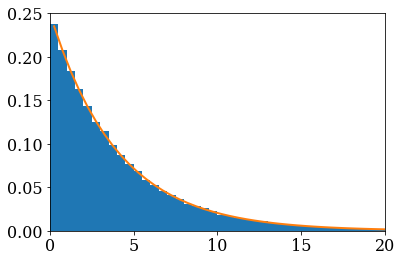

In [589]:
alpha = 0.25 # rate of the exponential distribution
x = numpy.random.random_sample(100000)
y = -1/alpha*numpy.log(1-x)

# Plots
binwidth=0.5
pyplot.xlim(0,20)
bins=numpy.arange(0.,21., binwidth)
pyplot.hist(y,bins,normed=True);

# Compute centers of bins
xc = bins[:-1] + binwidth/2
pyplot.plot(xc,alpha*numpy.exp(-alpha*xc), lw=2)

What do you think?

<p style='color:green; background-color:black; text-align:center'>
On voit que cela colle bien
<br>
Donc si F est inversible, on peut simuler le processus aléatoire à l'aide de l'inverse de F avec une distribution uniforme sur [0,1] 
</p>

### Von Neumann rejection method

In this method, one generates a set of random numbers with a given distribution $p_1(x)$, and then cleverly extracts from it a subset that obeys the desired distribution $p_2(x)$. In order for the method to work, there must exist a constant K such that we have, 

$$
{p_2(x)}\leq {Kp_1(x)},\quad \forall x.
$$

As an example, let us try to produce a set of numbers distributed according to the positive Gaussian distribution (meaning we only want positive numbers). For that purpose, we may use the exponential distribution (with rate parameter $\alpha =1$) as the starting distribution. Indeed, from the plot below, we see that the above criteria is met with $K=1.4$ ($K$ could have even been chosen a bit smaller).

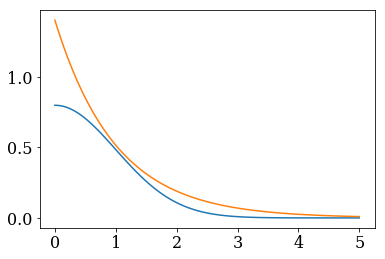

In [590]:
nx=100

xi =numpy.linspace(0,5,nx)

f1=2*numpy.exp(-xi**2/2.0)/numpy.sqrt(2*numpy.pi)
f2= 1.4*numpy.exp(-numpy.abs(xi))

pyplot.plot(xi,f1)
pyplot.plot(xi,f2)

The algorithm works as follows. 

1. We generate a number $x$ according to the exponential distribution.
2. We draw a random number $U$ between 0 and 1
3. We keep the number $x$ in our final set of randoms numbers if $U<\frac{p_2(x)}{Kp_1(x)}$.

The third step is the clever part. Imagine we draw a total of $N$ random numbers distributed according to $p_1$. In such a set, the number of times we observe a value $x_1$ in an interval $\Delta x$ centered around $x_1$ is about:

$$
n(x_1)\approx N p_1(x_1)\Delta x
$$

Because of step 3 this number will be reduced to

$$
n_f(x_1) \approx n(x_1) \frac{p_2(x_1)}{Kp_1(x)} = N\frac{p_2(x_1) \Delta x}{K}
$$

in the final set of random numbers. This implies that in this final set, the proportion of numbers centered around two values $x_1$ and $x_2$ is given by,

$$
\frac{n_f(x_1)}{n_f(x_2)}=\frac{p_2(x_1)}{p_2(x_2)}.
$$

We thus conclude that the resulting set of random numbers is indeed distributed according to $p_2$. Because of the step 3, we are systematically rejecting numbers from the initial sequence and the size $N_f$ of the final sequence is necessarilly smaller than the initial one ($N_f\approx N/K$). Therefore we should carefully choose $p_1$ so that $K$ can be made as small as possible.

Enough background, let us try the algorithm and see if it works as expected:

Size of accepted set h and expected size 1/K: 71461 71428.57142857143


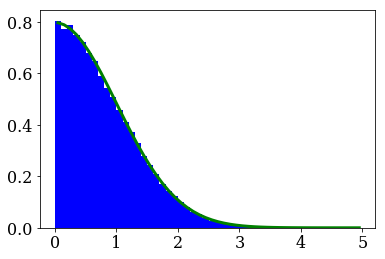

In [591]:
# Number of random numbers to draw according to p1 
N = 100000
K = 1.4

# Empty list for the final set of numbers
h=[]

for i in range(N):
    u1 = numpy.random.random_sample()
    
    # Distribute g according to the exponential distribution
    g = numpy.log(1/(1-u1))
    
    # Generate a second number for the acceptance/rejection condition
    u2 = numpy.random.random_sample()
    
    # Acceptance/rejection step
    ratio = 2*numpy.exp(-g**2/2.0)/numpy.sqrt(2*numpy.pi) / \
                (K*numpy.exp(-g))
    if (u2<ratio):
        # Append g to the set h
        h.append(g)

# Size of the accepted set
print("Size of accepted set h and expected size 1/K:", len(h), N/K)

# Plots
binwidth=0.1
bins=numpy.arange(0.,5.1, binwidth)
pyplot.hist(h,bins=numpy.arange(0.,5., binwidth),normed=True,color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
pyplot.plot(xc,2*numpy.exp(-xc**2/2.0)/numpy.sqrt(2*numpy.pi),lw=3,color='green')


Not bad! The algorithm produces the proper distribution and the final set has approximately the expected size. 

There are of course many ways to implement the Von Neumann rejection method. Here is another more efficient one making use of the `numpy.extract` method:

Acceptance ratio: 0.71232


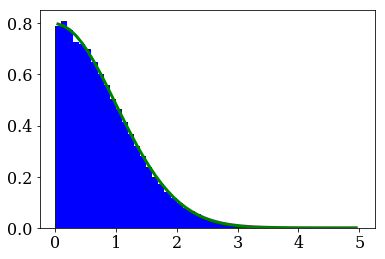

In [592]:
# Distribute g according to the exponential distribution
uniform1 = numpy.random.random_sample(N)
g = numpy.log(1/(1-uniform1))

# Probabilty of drawing g according to the exponential distribution
p_g_exp = numpy.exp(-g)

# Probability of drawing g according to the (positive) normal distribution
p_g_gauss = 2.0*numpy.exp(-g**2/2.0)/numpy.sqrt(2*numpy.pi)

# Draw a second uniform distribution for the acceptance
uniform2 = numpy.random.random_sample(N)

# Create acceptance mask
condition = uniform2 < p_g_gauss / (1.4*p_g_exp )

# Extract the accepted random numbers
h = numpy.extract(condition,g)

# Print the acceptance ratio
print("Acceptance ratio:",h.size/g.size)

# Plots
binwidth=0.1
bins=numpy.arange(0.,5.1, binwidth)
pyplot.hist(h,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
pyplot.plot(xc,2*numpy.exp(-xc**2/2.0)/numpy.sqrt(2*numpy.pi),lw=3,color='green')

## Challenge

1) Python has many built-in random number generators. Check-out the documentation and try a couple of ones. In particular, compare the output of the built-in expontential and Gaussian generators with the versions implemented above.

<p style='background-color:green'>
<br>
<br>
<br>
<br>
<br>
</p>

Text(0.5,1,'Loi normale')

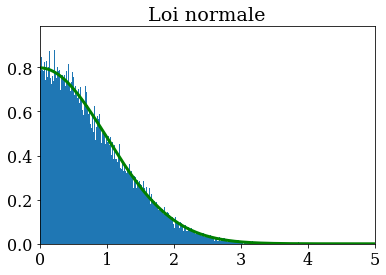

In [593]:
x=numpy.random.normal(0,1.,100000)
binwidth=10**(-2)
pyplot.xlim(0,5)
pyplot.hist(x,bins=numpy.arange(0.,6., binwidth),normed=True);
bins=numpy.arange(0.,5.1, binwidth)
xc = bins[:-1] + binwidth/2
pyplot.plot(xc,2*numpy.exp(-xc**2/2.0)/numpy.sqrt(2*numpy.pi),lw=3,color='green')
pyplot.title('Loi normale')

Text(0.5,1,'Loi exponentielle')

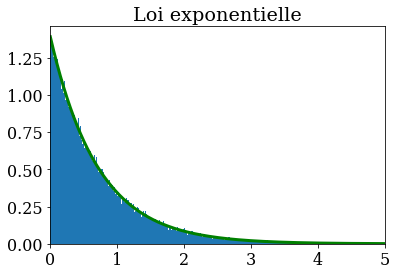

In [594]:
alpha=1.4
x=numpy.random.exponential(1/alpha,100000)
binwidth=10**(-2)
pyplot.xlim(0,5)
pyplot.hist(x,bins=numpy.arange(0.,6., binwidth),normed=True);
bins=numpy.arange(0.,5.1, binwidth)
xc = bins[:-1] + binwidth/2
pyplot.plot(xc,alpha*numpy.exp(-numpy.abs(xc)*alpha),lw=3,color='green')
pyplot.title('Loi exponentielle')

<p style='background-color:green'>
<br>
<br>
<br>
<br>
<br>
</p>

2) Another popular method to generate numbers according to the Gaussian distribution is known as the Box–Muller algorithm. Look up its definition on the web, try to implement it and verify that it works as expected.

<p style='background-color:green'>
<br>
<br>
<br>
<br>
<br>
</p>

<p style='color:green; background-color:black; text-align:center'>
Soient U1 et U2 deux variables aléatoires indépendantes uniformémént entre 0 et 1
<br> Soient $Z0= \sqrt{-2log\left ( U1 \right )}cos\left ( 2\pi U2 \right )$
<br> et
<br> $Z1= \sqrt{-2log\left ( U1 \right )}sin\left ( 2\pi U2 \right )$
<br> alors Z0 et Z1 sont des variables aléatoires indépendantes suivant une loi normale de moyenne 0 et d écart-type de 1
<br>
<br> Source: https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Box-Muller
</p>

Text(0.5,1,'Loi normale avec la méthode de Box-Muller')

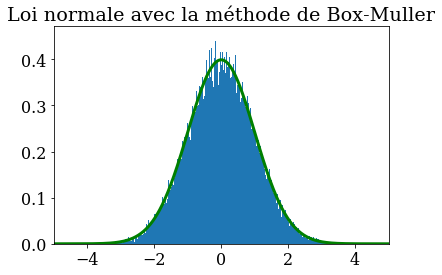

In [595]:
u1=numpy.random.random_sample(50000)
u2=numpy.random.random_sample(50000)
z0=numpy.sqrt(-2*numpy.log(u1))*numpy.cos(2*u2*numpy.pi)
z1=numpy.sqrt(-2*numpy.log(u1))*numpy.sin(2*u2*numpy.pi)
z=numpy.concatenate((z0,z1))

binwidth=10**(-2)
pyplot.xlim(-5,5)
pyplot.hist(z,bins=numpy.arange(-5.,6., binwidth),normed=True);
bins=numpy.arange(-5.,6., binwidth)
xc = bins[:-1] + binwidth/2
pyplot.plot(xc,numpy.exp(-xc**2/2.0)/numpy.sqrt(2*numpy.pi),lw=3,color='green')
pyplot.title('Loi normale avec la méthode de Box-Muller')


<p style='background-color:green'>
<br>
<br>
<br>
<br>
<br>
</p>

<p style='background-color:black'>
<br>
<br>
<br>
<br>
<br>
</p>

## Random walk, con't

In the first notebook of the open course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about) we discussed how the spreading of a quantity such as the concentration of food dye in a liquid could be described through a diffusion equation. We also started to consider another method which involves the modeling of the trajectories of the molecules. Now that we have learned more about random numbers in the second notebook of this module, we are ready to move forward and implement this second method.

### Stochastic equation for Brownian motion

The model equation we introduced for the evolution of the position of a molecule of dye is:

$$
dx=x(t+dt)−x(t)=ds
$$

$ds$ is a displacement resulting from the collision with surrounding water molecules and needs to be properly modelled. Technically speaking, the equation above is called a *stochastic differential equation* (SDE) as it contains a stochastic (or random) contribution. There are many phenomena that are modelled with such equations; besides Brownian motion, it is also widely used for the modelling of financial instruments like options.

Focusing for now on Brownian motion, let's see what happens if we model $ds$ as:

$$
ds=\sqrt{2\alpha dt}\cal{N(0,1)}
$$

where $\alpha$ is the same diffusion coefficient that one would use in the diffusion equation. Moreover, at each time step, $\cal{N(0,1)}$ is a random number that is generated from a normal (Gaussian) distribution $f(n)$, centered around $0$, and with variance equal to $1$. That is:

$$
f(n)=\frac{1}{\sqrt{2\pi}}e^{-\frac12 n^2}
$$

Below we will use Numpy's built-in function to sample the Gaussian distribution. In the previous notebook you learned to program your own version of such a routine so feel free to use it instead!

Here, we assume for simplicity that the Brownian motion takes place in a one-dimensional system. It is easy to extend the model to 2D or 3D problems by adding an identical equation for each extra dimension.

#### Integration of stochastic motion 

It's now time to integrate our stochastic equation. We begin by importing our usual set of libraries:

In [596]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

To warm up, we only track a particle originally at rest at $x=0$.

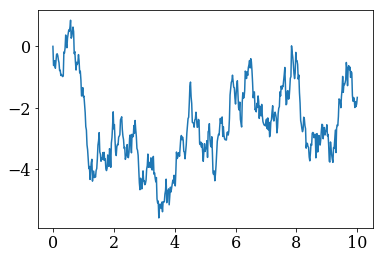

In [597]:
# Total simulation time
T=10.0

# Number of time steps and time interval dt
nt=500
dt=T/nt

# Diffusion coefficient
alpha=2.0

# Particle positions and initial condition
t = numpy.arange(0,T+dt,dt)
x = numpy.empty(nt+1)
x[0]=0

# Time integration (note the use of the numpy.random.normal function)
for i in range(nt):
    x[i+1]=x[i]+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1)

pyplot.plot(t,x)



As expected, we see that $x$ evolves in an erratic way, with random jumps (positive or negative) between each time instant. This is encouraging, but we need to verify that our model for $ds$ is indeed able to reproduce a diffusion process.

#### Comparison with the diffusion equation 

In order to estimate the evolution of a our dye, we need to follow the trajectories of a sample of molecules. From their positions, we can compute the predicted density of molecules through the expression,

$$
\rho(x,t) dx=n(x,t)/N
$$

where $n(x,t)$ represents, at a given time, the number of molecules of dye contained within an interval $dx$ centered around $x$ and $N$ is the total number of molecules used in the sample.

To test our stochastic model and make the comparison with the diffusion equation, we initialise the position of our sample of molecules with a Gaussian distribution:

$$
P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$ 

where $\sigma^2$ is the variance of the positions and $\mu$ is their average. As $n(x,0)=NP(x)dx$, we have $\rho(x,0)=P(x)$. In this case, the solution of the diffusion equation,

$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}
$$

can be computed exactly and is given by:

$$
\rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu)^2}{2\sigma_t^2}}
$$

with $\sigma^2_t = 2\alpha t + \sigma^2$. If all goes well we should recover this solution using our random walk technique.

Let us first initialise the positions of our sample molecules (we will follow 100000 of them) and check that their positions is distributed as expected:

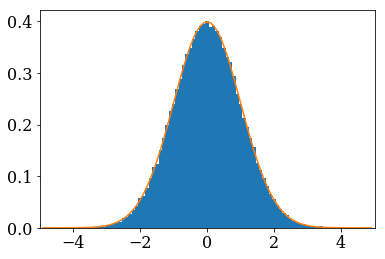

In [598]:
# Generate a set of initial positions based on the Gaussian distribution
npart=100000

# We set mu=0
sigma = 1.0
x0 = numpy.random.normal(loc=0,scale=sigma,size=npart)

# Generate bins centered around 0
binwidth=0.1
bins=numpy.arange(-5,5,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# Plot the histogram and expected distribution
pyplot.xlim(-5,5)
pyplot.hist(x0,bins,normed=True);
pyplot.plot(bin_centers, numpy.exp(-bin_centers**2/(2.0*sigma**2))/numpy.sqrt(2*numpy.pi*sigma**2))

Looks good! Now we compute the trajectories of the molecules and plot 20 of them as an illustration. 

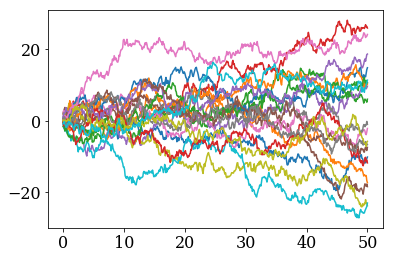

In [599]:
T=50.0
nt=500
dt=T/nt
alpha=2.0

t = numpy.arange(0,T+dt,dt)
x = numpy.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)

for i in range(20):
    pyplot.plot(t,x[:,i])

As required, the molecules follow very different trajectories. The sample is initially packed close to 0, but as time evoles, the molecules spread on average more and more. Let us now plot the histogram of the positions at the end of the simulation and compare it to the analytical solution of the diffusion equation:

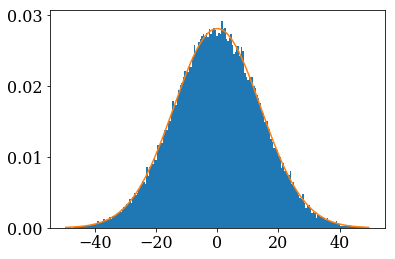

In [600]:
# Generate bins centered around 0
binwidth=0.5
bins=numpy.arange(-50,50,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
pyplot.hist(x[nt],bins,normed=True);

sigmat2=2*alpha*T+sigma**2
pyplot.plot(bin_centers, numpy.exp(-bin_centers**2/(2.0*sigmat2))/numpy.sqrt(2*numpy.pi*sigmat2))

Pretty good! Our particles have followed random trajectories but the evolution of their density is the same as if it was computed using the diffusion equation. Play with the parameters of the problem $(\alpha, \mu, \sigma, npart)$ and check that the algorithm works as expected.

### Challenge 

- Add as systematic contribution to the displacement $dx$,

$$
dx=cdt+\sqrt{2\alpha dt}\cal{N(0,1)}
$$

where $c$ is a constant and analyse the behaviour of the random walk. Can you guess the corresponding equation governing the evolution of the density in this case? What is the analitical solution for an initial Gaussian distribution?

<p style='color:green; background-color:black; text-align:center'>
Je prend en guise d illustration c=5.0
</p>

<p style='background-color:green'>
<br> 
<br> 
<br> 
<br> 
<br>
</p>

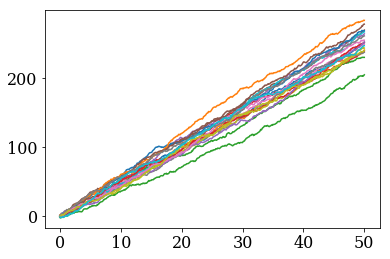

In [601]:
T=50.0
nt=500
dt=T/nt
alpha=2.0
c=5.0

t = numpy.arange(0,T+dt,dt)
x = numpy.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+c*dt+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)

for i in range(20):
    pyplot.plot(t,x[:,i])

<p style='color:green; background-color:black; text-align:center'>
On voit que malgré le mouvement brownien, le terme c*dt induit un mouvement d ensemble de toutes les particules dans les x positifs. C' est en fait un mouvement rectiligne uniforme avec un bruit dû au mouvement brownien
</p>

<p style='background-color:green'>
<br> 
<br> 
<br> 
<br> 
<br>
</p>

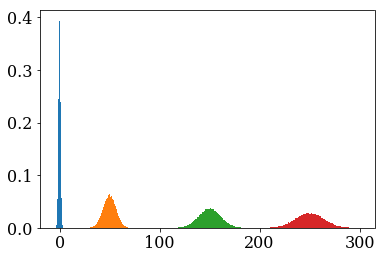

In [602]:
binwidth=0.5
bins=numpy.arange(-5,300,binwidth)
bins = bins + binwidth/2


bin_centers = bins[:-1]+binwidth/2


pyplot.hist(x[0],bins,normed=True);
pyplot.hist(x[100],bins,normed=True);
pyplot.hist(x[300],bins,normed=True);
pyplot.hist(x[nt],bins,normed=True);





<p style='color:green; background-color:black; text-align:center'>
Le graphe ci-dessus présente en réalité 4 graphes (Chaque pic en étant un)
<br> A t=0s ; t=100s; t=300s; t=nt=500s
<br> J ai disposé ainsi pour mieux voir l évolution de la courbe au cours du temps
<br> On voit que comme le cas précédent la courbe s élargit (écart-type augmente), mais aussi que le pic est déplacé dans les x croissants (espérance augmente)
<br> Au vu des valeurs, on peut suggérer que l'espérance translate de c.t
<br> Autrement dit,supposons que la solution est $\varrho \left ( x,t \right )= \frac{1}{\sqrt{2\pi \sigma _{t}^{2}}}e^{\frac{-(x-\mu _{t})^{2}}{2\sigma _{t}^{2}}}$
<br> avec $\left\{\begin{matrix}\sigma _{t}^{2}= 2\alpha t~+~\sigma^{2} \\ \mu _{t}= c.t~+~\mu\end{matrix}\right.$
<br> Ici on prend les valeurs initiales $\sigma=1.0$ et $\mu=0.0$
</p>

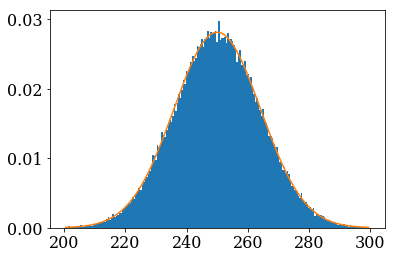

In [603]:
#Vérifions que notre solution colle bien aux données

mu=0.

binwidth=0.5
bins=numpy.arange(200,300,binwidth)
bins = bins + binwidth/2


bin_centers = bins[:-1]+binwidth/2


pyplot.hist(x[nt],bins,normed=True);

sigmat2=2*alpha*T+sigma**2
mut=mu + c*T
pyplot.plot(bin_centers, numpy.exp(-(bin_centers-mut)**2/(2.0*sigmat2))/numpy.sqrt(2*numpy.pi*sigmat2))

<p style='color:green; background-color:black; text-align:center'>
Cela colle bien aux données.
<br>Il est facile à vérifier que cette solution avec la condition initiale décrite plus haut est solution à l'équation $\frac{\partial \varrho }{\partial t}= \alpha \frac{\partial ^{2}\varrho }{\partial x^{2}}~+~c\frac{\partial \varrho }{\partial x}$
<br> Je me suis rendu compte en injectant ma solution que j'avais supposé dans l'équation de diffusion; Et j'ai vu qu'il y avait un terme supplémentaire qui est apparu (comparativement au cas précédent) et ce terme est exactement $c\frac{\partial \varrho }{\partial x}$, où le facteur 'c' est la vitesse d'ensemble des particules (où vitesse de la moyenne)
</p>

- Simulate the following random walk with a 'friction' term:

$$
dx=-\gamma x dt + \sqrt{2\alpha dt}\cal{N(0,1)}
$$

Check that the distribution reaches a steady state for $t\rightarrow \infty$. Can you guess the corresponding equation governing the evolution of the density in this case? What is analytical form for the steady state? These last two questions are not easy!

<p style='color:green; background-color:black; text-align:center'>
Prennons en guise d'illustration $\gamma =1,5.10^{-4}$
</p>

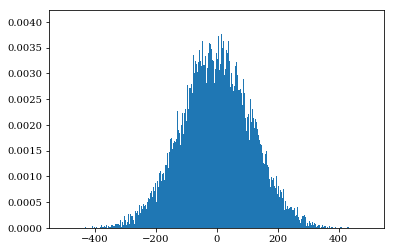

In [645]:
T=40000.0
nt=400
dt=T/nt
alpha=2.0
gamma=1.5*10**(-4)

t = numpy.arange(0,T+dt,dt)
x = numpy.empty([nt+1,npart])
sig = numpy.empty(nt+1)

x[0]=x0



for i in range(nt):
    
    x[i+1]=x[i]-gamma*x[i]*dt+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)


binwidth=0.5
bins=numpy.arange(-500,500,binwidth)
bins = bins + binwidth/2


bin_centers = bins[:-1]+binwidth/2


pyplot.hist(x[nt],bins,normed=True);









<p style='color:green; background-color:black; text-align:center'>
On voit que cela reste une gaussienne
<br> Voyons comment évoluent la variance et l'espérance:
</p>

Text(0.5,1,'Evolution de l esperance')

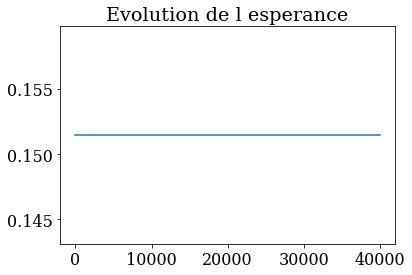

In [605]:
mu = numpy.empty(nt+1)
for i in range(nt):
    mu[i]=numpy.average(x)
mu[nt]=numpy.average(x)
pyplot.plot(t,mu);
pyplot.title('Evolution de l esperance')

<p style='color:green; background-color:black; text-align:center'>
Comme on peut le voir, l'espérance n'évolue pas
</p>

Text(0.5,1,'Evolution de la variance')

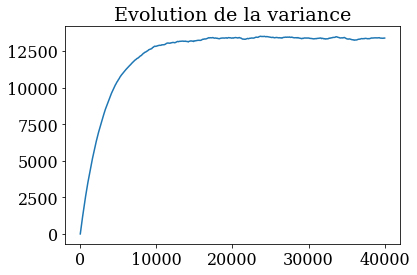

In [606]:
sig = numpy.empty(nt+1)
for i in range(nt):
    sig[i]=(numpy.sum(x[i]**2))/npart
sig[nt]=(numpy.sum(x[nt]**2))/npart
pyplot.plot(t,sig);
pyplot.title('Evolution de la variance')

<p style='color:green; background-color:black; text-align:center'>
<br> On voit donc que l'onatteint une solution stationnaire après +- 10000 secondes
<br>Ici, la variance a l'air d'évoluer exponentiellement. Ce graphe est typiquement le graphe de la fonction $f(x)=e^{\frac{-1}{x}}$
<br>On sait que en t=0, $\sigma _{t}^{2}(t=0)=\sigma^{2}$
<br> Posons $\sigma _{t}^{2}=\sigma^{2} + C_{1}e^{\frac{-C_{2}}{t}}$
<br> Pour calculer $C_{1}$, caculons $\sigma _{t}^{2}$ quand cela ne varie plus: 
</p>

In [607]:
print(sig[nt])

13384.756915


<p style='color:green; background-color:black; text-align:center'>
Remarquons que $\frac{\alpha}{\gamma }=\frac{2}{1,5.10^{-4}}=13333$
<br>On peut peut-être supposer que $C_{1}=\frac{\alpha}{\gamma }$
<br> Vérifions que ce n'est pas une coincidence avec d'autres valeurs de $\alpha$ et $\gamma$
</p>

In [608]:
alpha=5.0
gamma=3*10**(-5)

t = numpy.arange(0,T+dt,dt)
x = numpy.empty([nt+1,npart])
sig = numpy.empty(nt+1)

x[0]=x0



for i in range(nt):
    
    x[i+1]=x[i]-gamma*x[i]*dt+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)
    sig[i]=(numpy.sum(x[i]**2))/npart
sig[nt]=(numpy.sum(x[nt]**2))/npart

print(sig[nt])


151313.439596


<p style='color:green; background-color:black; text-align:center'>
On peut supposer que $C_{1}=\frac{\alpha}{\gamma }$
</p>

<p style='color:green; background-color:black; text-align:center'>
Cherchons $C_{2}$: A partir de notre relation supposée, on a que $C_{2}=-t.log\left ( \frac{\sigma_{t}^{2}-\sigma^{2}}{C_{1}} \right )$
</p>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


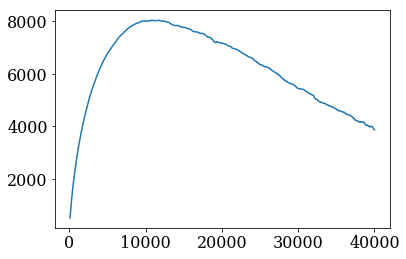

In [609]:
C2 = numpy.empty(nt+1)
sigma=1.
C2=-(t*numpy.log((((sig-sigma)*gamma)/alpha))) -13447*t*numpy.exp(-t)
pyplot.plot(t,C2);



<p style='color:green; background-color:black; text-align:center'>
On voit que $C_{2}$ n'est pas une constante. (ce qui est problématique!)
Je ne suis pas arrivé à résoudre intégralement ce problème
</p>

<p style='background-color:green'>
<br>
<br> 
<br>
<br> 
</p>



<p style='background-color:black'>
<br>
<br> 
<br>
<br> 
</p>

# The Ising Model

### A bit of theory

The Ising model allows to study ferromagnetism and can be used to study what is known as a phase transition.

Take a piece of iron at room temperature and subject it to a strong magnetic field (either using a permanent magnet or an electromagnet). After a while, switch off the magnetic field. You will observe that the piece of iron now acts itself  like a magnet. This property is shared by ferromagnetic materials which are able to sustain a non-zero magnetisation without any external field. However, this property vanishes above a certain temperature. This temperature is called the Curie temperature $T_c$, and depends on the ferromagnetic material considered. For iron,  $T_c$ is 1043 K. In thermodynamic terms we say that the ferromagnetic material undergoes a phase transition at the critical temperature $T_c$ since its properties change abruptly at that temperature.


In the Ising model of ferromagnetism, the material considered is described using unit magnets, called dipoles, distributed on a regular lattice and that can either point upwards or downwards (see figure 1). These dipoles represent the atoms that constitute the material and act like magnets oriented in different directions.

<img src="./figures/lattice1.png" alt="Drawing" style="width: 300px;"/>
Figure 1

In the simplest version of the Ising model, all the dipoles interact with their nearest neighbors (left, right, above, below). When two neighbors are aligned, the system is in a more stable configuration than when they are aligned in opposite directions (you may observe a similar property if you put two compasses near each other). The energy of the system can then be written as,

$$
E=-J\sum_{pairs(i,j)} s_i s_j,
$$

where the sum runs over all the pairs of dipoles in the system and $s_i$ denotes the 'spin' of the $i$-th dipole which is equal to $1$ or $-1$ wether the dipole points upwards or downwards; $J>0$ is the coupling constant for each pair of dipoles. We thus see that the energy is minimized and equal to $-JN_{pairs}$ when all the dipoles point in the same direction. 

Each time a dipole is flipped, the energy changes by an amount equal to,

$$
\Delta E = 2{J} s_i \sum_{j \in n(i)} s_j
$$

where $n(i)$ denotes all the neighbors of the $i$-th dipole. $\Delta E$ is positive or negative depending on the sign of $s_i$ and the total spin of the neighbors.

According to statistical mechanics, the probability of finding the system in a given configuration $X$ is equal to,

$$
p(X) = \frac{e^{-\beta E_X}}{Z}
$$

where $E_X$ is the potential energy of the configuration and $\beta=1/k_B T$ where $k_B$ is the so-called Boltzmann constant. In other words, the higher the potential energy, the less likely it is to find the system in the corresponding configuration. In the above formula $Z$ is a normalisation constant such that $\sum_X p(X)=1$,

$$
Z=\sum_X e^{-\beta E_X}.
$$

Knowing the probability of each state $X$ makes it possible to compute many quantities by simply performing averages (which is the whole idea behind statistical mechanics). For instance, the mean energy and the mean magnetisation are respectively,

$$
<E> = \frac{\sum_X E_X e^{-\beta E_X}}{Z}\\
<M> = \frac{\sum_X M_X e^{-\beta E_X}}{Z}
$$

with $M_X=\sum_{i=1}^N s_i$ for the given state. This quantity is particularly interesting as it is a signature for studying the phase transition. Above the Curie temperature, one has $<M>=0$ while $<M>$ has a finite non vanishing value below the Curie temperature.


### The Metropolis algorithm 

Computing averages over all possible states poses a computational difficulty when the number of lattice points becomes large. For example, for a $100\times100$ lattice, the number of possible states is $2^{10000}$ which is a huge number and makes brut force computation impossible. Thankfully, we can rely on stochastic methods and use, for instance, the Metropolis Monte Carlo algorithm.

Let us consider an initial state in which each spin takes a random orientation. 
The unit step of the Metropolis algorithm consists in choosing a random spin and in attempting to change its orientation. If the energy of the reversed spin decreases, the flipped state is chosen as the new configuration of the system.
Otherwise if the energy increases by $\Delta E$, the flip is only accepted with the probability,

$$
p_{\rm flip}=e^{-\beta\Delta E},
$$

otherwise the current state is retained as the new configuration. This process is repeated until a large enough number of states $X_k$ has been collected.

The averages we are interested in, such as the energy or the magnetisation, are then computed according to,

$$
<E> = \frac{\sum_k E_k}{N_k}\\
<M> = \frac{\sum_k M_k}{N_k}
$$

where the sums run over all the states generated through the Metropolis algorithm and $N_k$ is the total number of them.

Compared to the averages over all possible states, we see here that we only sum over a subset of them. However, thanks to the Metropolis algorithm, the states corresponding to different values of the energy are generated with the right distribution function and the averages above converge to the equilibrium values as $N_k\rightarrow \infty$. Technically speaking, the (normed) histogram of the states generated with the Metropolis algorithm converges to the same histogram
obtained using the full set of states weighted with their Boltzmann factor.

#### Verification 

Instead of providing a formal proof that the Metropolis algorithm works, let us check this for a simplified system in which all the spins are fixed except at one location.

Before doing so, we first adopt a non-dimensional unit system. 
Initially, our ferromagnetism problem has two parameters: the temperature $T$ and the coupling constant $J$. However, if we adopt as energy unit the product $k_b T$, our model has only one free parameter $\alpha=J/(k_b T)$ and the relevant formulas read:

$$
\Delta E = 2{\alpha} s_i \sum_{j \in n(i)} s_j \\
p_{\rm flip}=e^{-\Delta E}
$$

Any two materials at given temperatures can be described by the same equations as long as they have the same value of $\alpha$.

We first import a few libaries and load a $10\times 10$ initial state so that we all start from the same one.

In [610]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML
pyplot.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'

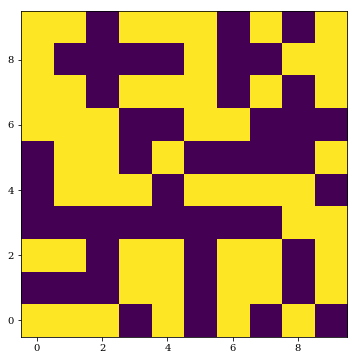

In [611]:
nx=10
ny=10

# Non-dimensional coupling constant J/(kb*T)
alpha = 0.1

# Initial spins at each site
sp = numpy.load('initial_state.npy')

pyplot.figure(figsize=(6,6))
pyplot.imshow(sp,interpolation="none",origin='lower')

Blue and red represent respectively sites that have their spins pointing down or up. Focus now the attention on the site with coordinates (x,y)=(5,5). It pointing down and has three neighbors pointing up and one pointing down.

We may compute the contribution to the energy coming from this site with the following subroutine (we assume that the system is periodic in both directions):

In [612]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy

In this case, we have:

In [613]:
print(energy_at_site(sp,alpha,-1,5,5))

0.2


If we flip the dipole at site (5,5) we get:

In [614]:
print(energy_at_site(sp,alpha,1,5,5))

-0.2


We conclude that the configuration with the spin pointing upwards has a lower energy. So as the dipole continually flips because of thermal fluctuations, it should be more frequently in that direction. The relative probability of having the spin down compared to the spin up is:

$$
\frac{p({\rm up})}{p({\rm downs})} = e^{-\Delta E}=e^{0.4}\approx 1.49
$$

Let's see if we can reproduce this result using a sequence of states generated with the Metropolis algorithm. To that end we first define a routine that flips the state at a given position with a probability $p_{\rm flip}=e^{-\Delta E}$:

In [615]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (numpy.random.random_sample()<numpy.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

Now generate a sequence of states with the Metropolis algorithm and compute the ratio of states pointing upwards or downwards:

In [616]:
NMC = 100000
states = numpy.empty(NMC+1)
states[0]=sp[5,5]

for n in range(0,NMC):
    metropolis_at_site(sp,alpha,5,5)
    states[n]=sp[5,5]

ups = numpy.extract(states==1, states).size
downs = NMC - ups
print(ups/downs)

1.488676521825693


Not bad! We see that the Metropolis algorithm generated the right proportion of states with the dipole pointing up or down (the ratio converges to the expected value as the number of states generated is increased). 

**Challenge:** Check that this is not a coincidence and that the metropolis algorithm gives the correct ratio of "ups" and "downs" for different lattice configurations. You may use the following routine to generate different ones with random initial dipole orientations.

<p style='background-color:green'>
<br>
<br> 
<br>
<br> 
</p>

In [617]:
def initial_state(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = numpy.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

<p style='color:green; background-color:black; text-align:center'>
Prennons le point (x,y)=(1,1)
</p>

In [618]:
sp[1,1]=initial_state(1,1)
print(sp[1,1])

1


<p style='color:green; background-color:black; text-align:center'>
C'est de spin 'up' 
<br> L'énergie dû à ce point est
</p>

In [619]:
print(energy_at_site(sp,alpha,-1,1,1))

0.0


<p style='color:green; background-color:black; text-align:center'>
<br> L'énergie dû à ce point si le spin était inversé:
</p>

In [620]:
print(energy_at_site(sp,alpha,1,1,1))

-0.0


<p style='color:green; background-color:black; text-align:center'>
On a $$ \frac{p({\rm up})}{p({\rm downs})} = e^{-\Delta E}=e^{0}= 1 $$
</p>

<p style='color:green; background-color:black; text-align:center'>
Vérifions l'algorithme Metropolis:
</p>

In [621]:
states[0]=sp[1,1]

for n in range(0,NMC):
    metropolis_at_site(sp,alpha,1,1)
    states[n]=sp[1,1]

ups = numpy.extract(states==1, states).size
downs = NMC - ups
print(ups/downs)

1.0


<p style='color:green; background-color:black; text-align:center'>
Cela marche!
<br> Re-essayons avec le point (x,y)=(4,3):
</p>

In [622]:
sp[4,3]=initial_state(5,5)[4,3]
print(sp[4,3])

-1


In [623]:
print(energy_at_site(sp,alpha,-1,4,3))
print(energy_at_site(sp,alpha,1,4,3))

-0.2
0.2


<p style='color:green; background-color:black; text-align:center'>
$$ \frac{p({\rm up})}{p({\rm downs})} = e^{-\Delta E}=e^{-0.4}\approx 0.67 $$
</p>

In [624]:
states[0]=sp[4,3]

for n in range(0,NMC):
    metropolis_at_site(sp,alpha,4,3)
    states[n]=sp[4,3]

ups = numpy.extract(states==1, states).size
downs = NMC - ups
print(ups/downs)

0.6697835960459524


<p style='color:green; background-color:black; text-align:center'>
Cela marche de nouveau!
</p>

<p style='background-color:green'>
<br>
<br> 
<br>
<br> 
</p>

### Back to the Ising Model 

Our objective in this section is to show that the ferromagnetic material is indeed subject to a phase transition at a given coupling constant $\alpha$ by using the Metropolis algorithm to generate a sequence of lattices with the right probabilities.
​
We first initialize the lattice with all spins pointing upwards (i.e. we assume that the material has been completely magnetized).

In [625]:
nx = 100
ny = 100

sp = numpy.ones([nx,ny])

We now need a routine to create a sequence of states by trying to flip the spins at random sites if the Metropolis condition is satisfied. Note that instead of keeping all the states, we attempt $nx*ny$ flips between the retained ones so that the system has a chance to change significantly.

In [626]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = numpy.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=numpy.random.randint(0,nx)
            iy=numpy.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

OK, let's compare what happens for two different values of the coupling constant $\alpha$. In the examples below, we gather 100 states; this number is quite low as we want to keep modest simulation times.

In [627]:
NMC=100
alpha=0.2

states_0_2 = ising_model_metropolis(sp, NMC, nx, ny, alpha)

In [628]:
NMC=100
sp = numpy.ones([nx,ny])
alpha=0.7
states_0_7 = ising_model_metropolis(sp, NMC, nx, ny, alpha)

In [629]:
fig = pyplot.figure(figsize=(6,3))

pyplot.subplot(1, 2, 1)
img1 = pyplot.imshow(states_0_2[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

pyplot.subplot(1, 2, 2)
img2 = pyplot.imshow(states_0_7[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate(i):
    img1.set_array(states_0_2[i])
    img2.set_array(states_0_7[i])

anim = animation.FuncAnimation(fig, animate, frames=NMC, interval=200)
pyplot.close()
HTML(anim.to_html5_video())

Great! We see that for $\alpha=0.2$, the spins remain disorganised while for $\alpha=0.7$ the system remains nearly completely magnetized. Does this make sense according to the theory we have outlined at the beginning of the notebook? 

<p style='color:green; background-color:black; text-align:center'>
Cela a du sens: Plus $\alpha$ est petit, plus la température est grande (via la relation $\alpha=J/(k_b T)$); Et donc une plus grande fluctuation des spins (empêchant le minimum d'énergie) dû à l'agitation thermique 
</p>

Let's also look at the evolution of the total spin (magnetisation) as the sequence is generated.

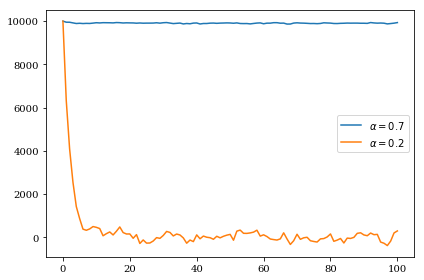

In [630]:
pyplot.figure()
pyplot.plot(states_0_7.sum(axis=(1,2)),label=r'$\alpha=0.7$')
pyplot.plot(states_0_2.sum(axis=(1,2)),label=r'$\alpha=0.2$')
pyplot.legend()
pyplot.tight_layout()

In both cases, the initial magnetisation is maximum. For $\alpha=0.2$, it rapidly decays and oscillates around a vanishing value; for $\alpha=0.7$, the magnetisation remains maxiumum. 

For $\alpha=2$, it takes a finite time before the system reaches a statistically steady state. In such case, when taking averages over the sequence of states to estimate a physical quantity, it might be necessary to sample more states and remove the initial ones which are far from equilibrium and that bias statistical averages. This is especially true close to the critical temperature as the magnetization decays rather slowly.

## Challenge

- Perform a series of runs with $\alpha \in [0 1]$ and plot the average energy of the system and its magnetisation as a function of $\alpha$. Estimate the critical value of $\alpha$ at which the phase transition occurs. Is it compatible with Onsager's exact solution for the system?

In [631]:
NMC=60
nx=60
ny=60

#Nous allons utilisé 11 valeurs de alpha entre 0.0 et 1.0 (équidistant)
magnetisation_average=numpy.ones(11)
energy_average=numpy.ones(11)
alpha=numpy.linspace(0.,1.,11)

#On utilise le l'algorithme Metropolis pour différentes valeurs de alpha
sp = numpy.ones([nx,ny])
states_0_1 = ising_model_metropolis(sp, NMC, nx, ny, alpha[0])
sp = numpy.ones([nx,ny])
states_0_2 = ising_model_metropolis(sp, NMC, nx, ny, alpha[1])
sp = numpy.ones([nx,ny])
states_0_3 = ising_model_metropolis(sp, NMC, nx, ny, alpha[2])
sp = numpy.ones([nx,ny])
states_0_4 = ising_model_metropolis(sp, NMC, nx, ny, alpha[3])
sp = numpy.ones([nx,ny])
states_0_5 = ising_model_metropolis(sp, NMC, nx, ny, alpha[4])
sp = numpy.ones([nx,ny])
states_0_6 = ising_model_metropolis(sp, NMC, nx, ny, alpha[5])
sp = numpy.ones([nx,ny])
states_0_7 = ising_model_metropolis(sp, NMC, nx, ny, alpha[6])
sp = numpy.ones([nx,ny])
states_0_8 = ising_model_metropolis(sp, NMC, nx, ny, alpha[7])
sp = numpy.ones([nx,ny])
states_0_9 = ising_model_metropolis(sp, NMC, nx, ny, alpha[8])
sp = numpy.ones([nx,ny])
states_0_10 = ising_model_metropolis(sp, NMC, nx, ny, alpha[9])
sp = numpy.ones([nx,ny])
states_0_11 = ising_model_metropolis(sp, NMC, nx, ny, alpha[10])


In [632]:
#Calculons la magnétisation moyenne pour les différentes vaeurs de alpha
magnetisation_average[0]=numpy.average(states_0_1)
magnetisation_average[1]=numpy.average(states_0_2)
magnetisation_average[2]=numpy.average(states_0_3)
magnetisation_average[3]=numpy.average(states_0_4)
magnetisation_average[4]=numpy.average(states_0_5)
magnetisation_average[5]=numpy.average(states_0_6)
magnetisation_average[6]=numpy.average(states_0_7)
magnetisation_average[7]=numpy.average(states_0_8)
magnetisation_average[8]=numpy.average(states_0_9)
magnetisation_average[9]=numpy.average(states_0_10)
magnetisation_average[10]=numpy.average(states_0_11)

Text(0.5,1,'Magnétisation moyenne en fonction de alpha')

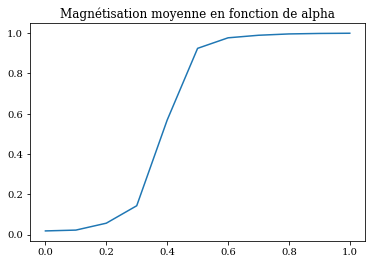

In [633]:
pyplot.plot(alpha,magnetisation_average)
pyplot.title('Magnétisation moyenne en fonction de alpha')

In [634]:
#Pour chaque point d'espace, calculons l'énergie dû à l'interaction du spin à cet endroit avec ces 4 voisins
for i in range(0,40):
    for j in range(0,40):
        states_0_1[i,j]=energy_at_site(states_0_1,alpha[0],states_0_1[i,j],i,j)
        states_0_2[i,j]=energy_at_site(states_0_2,alpha[1],states_0_2[i,j],i,j)
        states_0_3[i,j]=energy_at_site(states_0_3,alpha[2],states_0_3[i,j],i,j)
        states_0_4[i,j]=energy_at_site(states_0_4,alpha[3],states_0_4[i,j],i,j)
        states_0_5[i,j]=energy_at_site(states_0_5,alpha[4],states_0_5[i,j],i,j)
        states_0_6[i,j]=energy_at_site(states_0_6,alpha[5],states_0_6[i,j],i,j)
        states_0_7[i,j]=energy_at_site(states_0_7,alpha[6],states_0_7[i,j],i,j)
        states_0_8[i,j]=energy_at_site(states_0_8,alpha[7],states_0_8[i,j],i,j)
        states_0_9[i,j]=energy_at_site(states_0_9,alpha[8],states_0_9[i,j],i,j)
        states_0_10[i,j]=energy_at_site(states_0_10,alpha[9],states_0_10[i,j],i,j)
        states_0_11[i,j]=energy_at_site(states_0_11,alpha[10],states_0_11[i,j],i,j)

In [635]:
#Calculons l'énergie moyenne
energy_average[0]=numpy.average(states_0_1)
energy_average[1]=numpy.average(states_0_2)
energy_average[2]=numpy.average(states_0_3)
energy_average[3]=numpy.average(states_0_4)
energy_average[4]=numpy.average(states_0_5)
energy_average[5]=numpy.average(states_0_6)
energy_average[6]=numpy.average(states_0_7)
energy_average[7]=numpy.average(states_0_8)
energy_average[8]=numpy.average(states_0_9)
energy_average[9]=numpy.average(states_0_10)
energy_average[10]=numpy.average(states_0_11)

Text(0.5,1,'Energie moyenne en fonction de alpha')

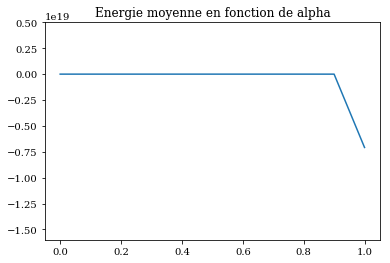

In [636]:
pyplot.plot(alpha,energy_average)
pyplot.ylim(-1.6*10**19,0.5*10**19)
pyplot.title('Energie moyenne en fonction de alpha')

<p style='color:green; background-color:black; text-align:center'>
Remarquons sur le graphe de la magnétisation moyenne en fonction de $\alpha$, que le changement de phase se fait pour des valeurs de $\alpha$ entre 0.3 et 0.5. Or, d'après la solution d'Onsager $\alpha=0.44$
<br> Source: http://www.lps.ens.fr/~krzakala/ISINGMODEL.pdf

<br> Donc notre résultat est compatible avec la solution de Onsager
</p>

<p style='background-color:green'>
<br>
<br> 
<br>
<br> 
</p>

- Redo the analysis with a different set of boundary conditions for the lattice and a different initial lattice configuration. For example, you could assume that on the borders all the spins are pointing upwards on the borders while they are randomly oriented in the bulk

<p style='background-color:green'>
<br>
<br> 
<br>
<br> 
</p>

<p style='color:green; background-color:black; text-align:center'>
Prennons le cas où les bords sont de spins 'up' et à l'intérieur tous les spins sont distribués de manière aléatoire
</p>

In [637]:
#Prennons le cas où tous les spins sont aléatoires
sp=initial_state(80,80)

In [638]:
#Imposons sur tout les bords un spin up
sp[0,:]=1.
sp[:,0]=1.
sp[-1,:]=1.
sp[:,-1]=1.

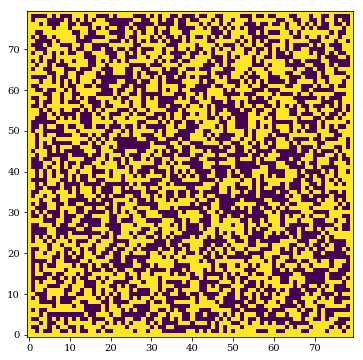

In [639]:
pyplot.figure(figsize=(6,6))
pyplot.imshow(sp,interpolation="none",origin='lower')

<p style='color:green; background-color:black; text-align:center'>
Voyons pour $\alpha=0.1$ et $\alpha=10^{20}$. Je prend cette dernière aleur afin de se rapprocher d'assez près du 0K de température
</p>

In [640]:
ssp=numpy.copy(sp)
NMC=80
alpha1=0.1
alpha2=10.**30
nx=80
ny=80

state1 = ising_model_metropolis(sp, NMC, nx, ny, alpha1)

state2 = ising_model_metropolis(ssp, NMC, nx, ny, alpha2)

fig = pyplot.figure(figsize=(6,3))

pyplot.subplot(1, 2, 1)
img1 = pyplot.imshow(state1[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

pyplot.subplot(1, 2, 2)
img2 = pyplot.imshow(state2[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate2(i):
    img1.set_array(state1[i])
    img2.set_array(state2[i])

anim = animation.FuncAnimation(fig, animate2, frames=NMC, interval=200)
pyplot.close()
HTML(anim.to_html5_video())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


<p style='color:green; background-color:black; text-align:center'>
On ne part pas d'un aimant, contrairement au cas décrit au mooc. Ici, globalement tous les spins sont aléatoires.
<br> Pour $\alpha=0.1$, il n'y a pas d'aimantation
<br> Pour $\alpha=10^{30}$, il y a une aimantation que partielle. Cela est cohérent pour un matériau dont tous ces spins sont distribués de manière aléatoires. Pour avoir une aimantation totale, il faut atteindre le 0 absolu de température; Autrement dit pour $\alpha\rightarrow+\infty $
</p>

In [641]:
sp=initial_state(80,80)
sp[0,:]=1.
sp[:,0]=1.
sp[-1,:]=1.
sp[:,-1]=1.
nx=80
ny=80
NMC=80
alpha=numpy.linspace(0.,10.**6,11)



#Nous allons utilisé 11 valeurs de alpha entre 0.0 et 1.0 (équidistant)
magnetisation_average=numpy.ones(11)
energy_average=numpy.ones(11)


#On utilise le l'algorithme Metropolis pour différentes valeurs de alpha
ssp=numpy.copy(sp)
states_0_1 = ising_model_metropolis(sp, NMC, nx, ny, alpha[0])
sp=ssp
states_0_2 = ising_model_metropolis(sp, NMC, nx, ny, alpha[1])
sp=ssp
states_0_3 = ising_model_metropolis(sp, NMC, nx, ny, alpha[2])
sp=ssp
states_0_4 = ising_model_metropolis(sp, NMC, nx, ny, alpha[3])
sp=ssp
states_0_5 = ising_model_metropolis(sp, NMC, nx, ny, alpha[4])
sp=ssp
states_0_6 = ising_model_metropolis(sp, NMC, nx, ny, alpha[5])
sp=ssp
states_0_7 = ising_model_metropolis(sp, NMC, nx, ny, alpha[6])
sp=ssp
states_0_8 = ising_model_metropolis(sp, NMC, nx, ny, alpha[7])
sp=ssp
states_0_9 = ising_model_metropolis(sp, NMC, nx, ny, alpha[8])
sp=ssp
states_0_10 = ising_model_metropolis(sp, NMC, nx, ny, alpha[9])
sp=ssp
states_0_11 = ising_model_metropolis(sp, NMC, nx, ny, alpha[10])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


In [642]:
#Calculons la magnétisation moyenne pour les différentes vaeurs de alpha
magnetisation_average[0]=numpy.average(states_0_1)
magnetisation_average[1]=numpy.average(states_0_2)
magnetisation_average[2]=numpy.average(states_0_3)
magnetisation_average[3]=numpy.average(states_0_4)
magnetisation_average[4]=numpy.average(states_0_5)
magnetisation_average[5]=numpy.average(states_0_6)
magnetisation_average[6]=numpy.average(states_0_7)
magnetisation_average[7]=numpy.average(states_0_8)
magnetisation_average[8]=numpy.average(states_0_9)
magnetisation_average[9]=numpy.average(states_0_10)
magnetisation_average[10]=numpy.average(states_0_11)

Text(0.5,1,'Magnétisation moyenne en fonction de alpha')

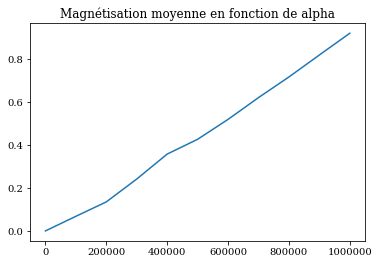

In [643]:
pyplot.plot(alpha,magnetisation_average)
pyplot.title('Magnétisation moyenne en fonction de alpha')

<p style='color:green; background-color:black; text-align:center'>
Comme nous pouvons le voir, il n' a pas de transition 'brute'. Les spins s'oriente progressivement dans la direction 'up'. Un tel matériau n'est pas ferromagnétique. (ce matériau étant défini par ses conditions initiales)
</p>

<p style='color:green; background-color:black; text-align:center'>
Essayons avec les mêmes conditions initales sauf avec tous les bords 'down':
</p>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


Text(0.5,1,'Magnétisation moyenne en fonction de alpha')

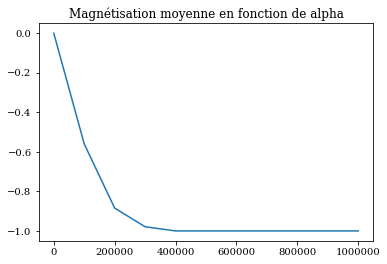

In [644]:
sp=initial_state(80,80)
sp[0,:]=-1.
sp[:,0]=-1.
sp[-1,:]=-1.
sp[:,-1]=-1.
nx=80
ny=80
NMC=80
alpha=numpy.linspace(0.,10.**6,11)



#Nous allons utilisé 11 valeurs de alpha entre 0.0 et 1.0 (équidistant)
magnetisation_average=numpy.ones(11)
energy_average=numpy.ones(11)


#On utilise le l'algorithme Metropolis pour différentes valeurs de alpha
ssp=numpy.copy(sp)
states_0_1 = ising_model_metropolis(sp, NMC, nx, ny, alpha[0])
sp=ssp
states_0_2 = ising_model_metropolis(sp, NMC, nx, ny, alpha[1])
sp=ssp
states_0_3 = ising_model_metropolis(sp, NMC, nx, ny, alpha[2])
sp=ssp
states_0_4 = ising_model_metropolis(sp, NMC, nx, ny, alpha[3])
sp=ssp
states_0_5 = ising_model_metropolis(sp, NMC, nx, ny, alpha[4])
sp=ssp
states_0_6 = ising_model_metropolis(sp, NMC, nx, ny, alpha[5])
sp=ssp
states_0_7 = ising_model_metropolis(sp, NMC, nx, ny, alpha[6])
sp=ssp
states_0_8 = ising_model_metropolis(sp, NMC, nx, ny, alpha[7])
sp=ssp
states_0_9 = ising_model_metropolis(sp, NMC, nx, ny, alpha[8])
sp=ssp
states_0_10 = ising_model_metropolis(sp, NMC, nx, ny, alpha[9])
sp=ssp
states_0_11 = ising_model_metropolis(sp, NMC, nx, ny, alpha[10])


#Calculons la magnétisation moyenne pour les différentes vaeurs de alpha
magnetisation_average[0]=numpy.average(states_0_1)
magnetisation_average[1]=numpy.average(states_0_2)
magnetisation_average[2]=numpy.average(states_0_3)
magnetisation_average[3]=numpy.average(states_0_4)
magnetisation_average[4]=numpy.average(states_0_5)
magnetisation_average[5]=numpy.average(states_0_6)
magnetisation_average[6]=numpy.average(states_0_7)
magnetisation_average[7]=numpy.average(states_0_8)
magnetisation_average[8]=numpy.average(states_0_9)
magnetisation_average[9]=numpy.average(states_0_10)
magnetisation_average[10]=numpy.average(states_0_11)

pyplot.plot(alpha,magnetisation_average)
pyplot.title('Magnétisation moyenne en fonction de alpha')

<p style='color:green; background-color:black; text-align:center'>
Après un certain $\alpha$, le matériau a une magnétisation opposé. (globalement 'down')
<br>En réalité ce n'est pas surprenant car la différence entre le premier cas et le second c'est que le champ magnétique est de sens opposé; Et cela se voit à travers les bords
</p>

# Conclusion

<p style='color:green; background-color:black; text-align:center'>
On a vu à travers ce mooc comment simplifier un problème dont le système a un très grand nombre de degré de liberté en considérant les processus se déroulant de manière aléatoire selon unecertaine loi de probabilité
</p>